In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
np.set_printoptions(suppress=True)

In [2]:
ROCK,PAPER,SCISSORS = 0,1,2
NUM_ACTIONS = 3 #How many actions a player can take
strategy = np.array([0.0, 0.0, 0.0]) #define strategy of the player (to start)

In [3]:
def value(p1, p2):
    if p1 == p2:
        return 0
    elif (p1-1) % NUM_ACTIONS == p2:
        return 1
    else:
        return -1

In [4]:
def normalize(strategy):
    strategy = np.copy(strategy)
    normalizingSum = np.sum(strategy)
    if normalizingSum > 0:
        strategy /= normalizingSum
    else:
        strategy = np.ones(strategy.shape[0]) / strategy.shape[0]
    return strategy

In [5]:
def getStrategy(regretSum):
    return normalize(np.maximum(regretSum, 0))

In [6]:
def getAverageStrategy(strategySum):
    return normalize(strategySum)

In [7]:
def getAction(strategy):
    strategy = strategy / np.sum(strategy) #normalize
    return np.searchsorted(np.cumsum(strategy), random.random())

In [8]:
def innerTrain(regretSum, strategySum, oppStrategy):
    #accumulate the current strategy based on regret
    strategy = getStrategy(regretSum)
    strategySum += strategy
        
    #select my action and opponent action
    myAction = getAction(strategy)
    otherAction = getAction(oppStrategy)
        
    #for rock paper scissors
    actionUtility = np.zeros(NUM_ACTIONS)
    actionUtility[otherAction] = 0
    actionUtility[(otherAction + 1) % NUM_ACTIONS] = 1
    actionUtility[(otherAction - 1) % NUM_ACTIONS] = -1
    
    #accumulate
    regretSum += actionUtility - actionUtility[myAction]
    
    return regretSum, strategySum

In [9]:
def train(iterations, oppStrategy):
    regretSum = np.zeros(NUM_ACTIONS)
    strategySum = np.zeros(NUM_ACTIONS)
    
    for i in range(iterations):
        regretSum, strategySum = innerTrain(regretSum, strategySum, oppStrategy)
        
    return strategySum

In [24]:
def train2p(oiterations, iterations):
    strategySumP1 = np.zeros(NUM_ACTIONS)
    strategySumP2 = np.zeros(NUM_ACTIONS)
    
    for j in range(oiterations):
        oppStrategy = getAverageStrategy(strategySumP2)
        regretSumP1 = np.zeros(NUM_ACTIONS)
        for i in range(iterations):
            #train the first player
            regretSumP1, strategySumP1 = innerTrain(regretSumP1, strategySumP1, oppStrategy)
        
        oppStrategy = getAverageStrategy(strategySumP1)
        regretSumP2 = np.zeros(NUM_ACTIONS)
        for i in range(iterations):
            #train the second player
            regretSumP2, strategySumP2 = innerTrain(regretSumP2, strategySumP2, oppStrategy)
        
        print("%3d" % j, normalize(strategySumP1), normalize(strategySumP2))
        
    return strategySumP1, strategySumP2

In [11]:
def plotGames(strategy, oppStrategy):
    vvv = []
    for j in range(200):
        vv = 0
        for i in range(100):
            myAction = getAction(strategy)
            otherAction = getAction(oppStrategy)
            vv += value(myAction, otherAction)
        vvv.append(vv)
    plt.plot(sorted(vvv))
    print(f"mean: {np.mean(vvv)}\nmedian: {np.median(vvv)}")

[0.33 0.33 0.33]
mean: 0.735
median: 1.0


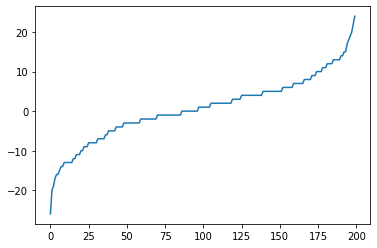

In [12]:
#here we are not exploiting at all...
strategy = np.array([0.33,0.33,0.33])
oppStrategy = np.array([0.4, 0.3, 0.3])
#strategy = np.array([0,1,0]) #only throw paper, should be the optimal strategy for an agent that favours rock
print(strategy)
plotGames(strategy, oppStrategy)

In [13]:
#train against the fixed strategy
strategySum = train(100000, oppStrategy)
getAverageStrategy(strategySum)

array([0.00234112, 0.99706361, 0.00059527])

[0.00234112 0.99706361 0.00059527]
mean: 9.965
median: 10.0


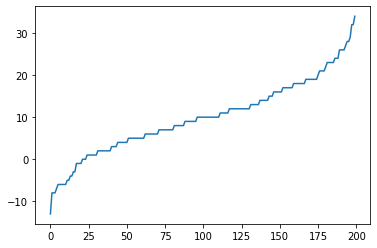

In [14]:
#plot the trained strategy (1 player)
strategy = getAverageStrategy(strategySum)
print(strategy)
plotGames(strategy, oppStrategy)

In [26]:
#now play when both agents minimize regret
s1, s2 = train2p(25, 10000)
getAverageStrategy(s1), getAverageStrategy(s2)

  0 [0.15226749 0.79047787 0.05725465] [0.00003333 0.00003333 0.99993333]
  1 [0.57600041 0.3953056  0.02869399] [0.00003333 0.499925   0.50004167]
  2 [0.38405583 0.26359262 0.35235155] [0.29855153 0.36799847 0.33345   ]
  3 [0.2890424  0.19912261 0.51183499] [0.47364996 0.27608111 0.25026893]
  4 [0.2315437  0.35882831 0.40962799] [0.38119397 0.22108477 0.39772126]
  5 [0.35938648 0.29922908 0.34138444] [0.48142237 0.18691682 0.33166082]
  6 [0.33958532 0.36779468 0.29261999] [0.41291159 0.23472119 0.35236722]
  7 [0.40075451 0.34319883 0.25604666] [0.36136516 0.32968598 0.30894886]
  8 [0.3603822  0.40778699 0.23183081] [0.32126886 0.40374279 0.27498835]
  9 [0.32438176 0.36724352 0.30837472] [0.28957664 0.36637213 0.34405123]
 10 [0.29510579 0.33478415 0.37011006] [0.35231824 0.33311657 0.31456519]
 11 [0.27168275 0.38897407 0.33934317] [0.32331592 0.30536658 0.3713175 ]
 12 [0.32654268 0.35919645 0.31426087] [0.30001909 0.28481004 0.41517087]
 13 [0.37416348 0.3339806  0.29185593]

(array([0.34702659, 0.2976978 , 0.3552756 ]),
 array([0.30517924, 0.35738   , 0.33744076]))

mean: -0.23
median: -1.0


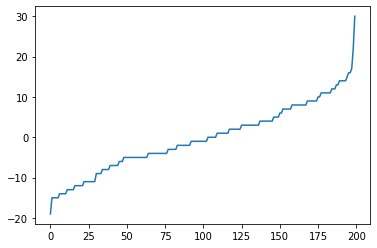

In [27]:
#plot the trained strategy (2 player)
plotGames(s1, s2)